## Plots delays, throughputs, packet loss and path for a selected link

In [1]:
%matplotlib inline
from elasticsearch import Elasticsearch
from elasticsearch.helpers import scan
from datetime import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import gridspec
from datetime import datetime
import numpy as np
import pandas as pd

es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60)
indices = "network_weather-2017.8.*"

my_query = {}

from sklearn import tree

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_curve, auc

import time
from sklearn.model_selection import train_test_split

##  Select your link

In [2]:
# sS='UC'
# srcSiteOWDServer = "192.170.227.160"
# srcSiteThroughputServer = "192.170.227.162"

sS= 'pic'
srcSiteOWDServer = "193.109.172.188"
#srcSiteThroughputServer = "128.142.223.246"

# dS='IU'
# destSiteOWDServer = "149.165.225.223"
# destSiteThroughputServer = "149.165.225.224"

# dS='UIUC'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.96.9"

# dS='ICCN'
# destSiteOWDServer = "72.36.96.4"
# destSiteThroughputServer = "72.36.126.132"

dS= 'CERN-PROD'
destSiteOWDServer = "128.142.223.247"
#destSiteThroughputServer = "193.109.172.187"

## Get the data from Elasticsearch, and store the record based on its type

In [3]:
my_query = {
    'query': { 
       'bool':{
            'must':[
                    {'range': {'timestamp': {'gte': '20170814T000000Z', 'lt': '20170821T000000Z'}}},
                        {'bool':
                            {'should':[
                                {'term': {'src': srcSiteOWDServer}},
                                #{'term': {'src': srcSiteThroughputServer}},
                                #{'term': {'src': destSiteOWDServer}},
                                #{'term': {'src': destSiteThroughputServer}}
                            ]}
                        },
                        {'bool':
                            {'should':[
                                {'term': {'dest': destSiteOWDServer}},
                                #{'term': {'dest': destSiteThroughputServer}},
                                #{'term': {'dest': srcSiteOWDServer}},
                                #{'term': {'dest': srcSiteThroughputServer}}
                            ]}
                        }
                    ]
                }
        
        }
    }


scroll = list(scan(client=es, index=indices, query=my_query))


In [4]:
site = {srcSiteOWDServer: sS, destSiteOWDServer:dS}
data = {sS:pd.DataFrame(),dS:pd.DataFrame()}
epoch = datetime.utcfromtimestamp(0)
count = 0
print(epoch)

for res in scroll:
    if count<10: print(res)
    count += 1
#     dt=datetime.strptime(res['_source']['timestamp'], '%Y-%m-%dT%H:%M:%S') # for data before Oct. 15 2016
    dt=datetime.utcfromtimestamp(res['_source']['timestamp']/1000.0)
    ts = (dt - epoch).total_seconds() * 1000.0
    s=site[res['_source']['src']]
    data[s].set_value(ts, 'timestamp', dt)
    column_type = res['_type']
    if column_type == 'packet_loss_rate':
        data[s].set_value( ts, 'packet_loss', res['_source']['packet_loss'])
    if count<2: print(dt)

1970-01-01 00:00:00
{'_index': 'network_weather-2017.8.18', '_type': 'latency', 'sort': [179], '_id': 'AV3yxEOtNILXDji8zuhr', '_source': {'src_host': 'psl01.pic.es', 'srcVO': 'ATLAS', 'MA': '193.109.172.188', 'delay_sd': 27.072149155907862, 'delay_mean': 17.93888333333333, 'destProduction': True, 'dest': '128.142.223.247', 'destVO': 'ATLAS', 'delay_median': 15.43, 'destSite': 'CERN-PROD', 'ipv6': False, 'dest_host': 'perfsonar-lt.cern.ch', 'timestamp': 1503016453000, 'src': '193.109.172.188', 'srcProduction': True, 'srcSite': 'pic'}, '_score': None}
2017-08-18 00:34:13
{'_index': 'network_weather-2017.8.18', '_type': 'latency', 'sort': [180], '_id': 'AV3yxEOtNILXDji8zuhv', '_source': {'src_host': 'psl01.pic.es', 'srcVO': 'ATLAS', 'MA': '193.109.172.188', 'delay_sd': 16.95154958629643, 'delay_mean': 16.8573, 'destProduction': True, 'dest': '128.142.223.247', 'destVO': 'ATLAS', 'delay_median': 15.41, 'destSite': 'CERN-PROD', 'ipv6': False, 'dest_host': 'perfsonar-lt.cern.ch', 'timestamp'

In [5]:
data[sS].sort_index(inplace=True) 
data[sS].describe()

print(data[sS])

                       timestamp  packet_loss
1.502669e+12 2017-08-14 00:00:08     0.000000
1.502669e+12 2017-08-14 00:00:20     0.000000
1.502669e+12 2017-08-14 00:01:08     0.000000
1.502669e+12 2017-08-14 00:01:21     0.000000
1.502669e+12 2017-08-14 00:02:08     0.000000
1.502669e+12 2017-08-14 00:02:21     0.000000
1.502669e+12 2017-08-14 00:03:08     0.000000
1.502669e+12 2017-08-14 00:03:21     0.000000
1.502669e+12 2017-08-14 00:04:08     0.000000
1.502669e+12 2017-08-14 00:04:21     0.000000
1.502669e+12 2017-08-14 00:05:08     0.000000
1.502669e+12 2017-08-14 00:05:21     0.000000
1.502669e+12 2017-08-14 00:06:08     0.000000
1.502669e+12 2017-08-14 00:06:21     0.000000
1.502669e+12 2017-08-14 00:07:09     0.000000
1.502669e+12 2017-08-14 00:07:21     0.000000
1.502669e+12 2017-08-14 00:08:09     0.000000
1.502669e+12 2017-08-14 00:08:26     0.000000
1.502669e+12 2017-08-14 00:09:09     0.000000
1.502669e+12 2017-08-14 00:09:26     0.000000
1.502669e+12 2017-08-14 00:10:09  

### Extract values

In [6]:
F = data[sS]
Fpl = F[F.packet_loss.notnull()]

#### interpolate all the values and leave only onese where all 4 measurements are there

In [7]:
NF=F.interpolate(method='index',limit=1,limit_direction='both')
NFall = NF[NF.packet_loss.notnull()]

print(NFall.shape)

(20620, 2)


In [8]:
print(NF.shape)

(20620, 2)


In [9]:
print( 'packet loss forward: ', Fpl.shape[0])

packet loss forward:  19935


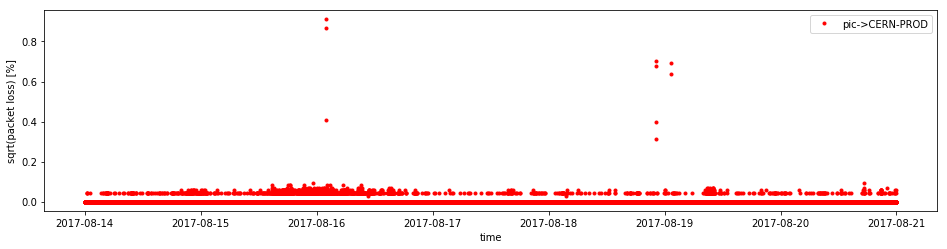

In [10]:
plt.figure(figsize=[16, 17])
gs = gridspec.GridSpec(4, 1)

ax2 = plt.subplot(gs[1])
ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()

plt.show()

### Boosted Decision Trees

In [11]:
start_time = time.clock()

predicted_flag_array = np.zeros((24*3600), dtype=np.int)
auc_score_array = np.zeros((24*3600), dtype=np.float)
score_holder_array = np.zeros(3600, dtype=np.float)
anomaly_array = np.ones(3600, dtype=np.int)
not_anomaly_array = np.zeros(3600, dtype=np.int)

In [12]:
#separate data into Reference and Subject
def trainer(reference, subject, n_series):
    
    reference.loc[:].Flag = 0 # Flagging the reference data as 0
    X_ref = reference.loc[:, range(n_series)] #refers to the feature set data
    y_ref = reference.Flag #refers to the label data
    
    subject.loc[:].Flag = 1 # Flagging the subject data as 1
    X_sub = subject.loc[:, range(n_series)] #refers to the feature set data
    y_sub = subject.Flag #refers to the label data

    #separate Reference into Train and Test
    X_ref_train, X_ref_test, y_ref_train, y_ref_test = train_test_split(X_ref, y_ref, test_size = 0.3, random_state=50)

    #separate Subject into Train and Test
    X_sub_train, X_sub_test, y_sub_train, y_sub_test = train_test_split(X_sub, y_sub, test_size = 0.3, random_state=50)
    
    #Combine reference and subject train datasets
    X_train_frames = [X_ref_train, X_sub_train] 
    X_train = pd.concat(X_train_frames, ignore_index=True) #combine the 70% training data features from both reference and subject
    
    y_train_frames = [y_ref_train, y_sub_train]
    y_train = pd.concat(y_train_frames, ignore_index=True) #combine the 70% training data label from both reference and subject

    #Combine reference and subject test datasets
    X_test_frames = [X_ref_test, X_sub_test]
    X_test = pd.concat(X_test_frames, ignore_index=True) #combine the 30% training data features from both reference and subject
    
    y_test_frames = [y_ref_test, y_sub_test]
    y_test = pd.concat(y_test_frames, ignore_index=True) #combine the 30% training data label from both reference and subject

    #Train model using the combined train data
    clf = AdaBoostClassifier(n_estimators=50)
    clf.fit(X_train, y_train) 
    #train an AdaBoost model to be able to tell the difference between the reference and subject data

    #Predict using the combined test data
    y_predict = clf.predict(X_test)
    #use the trained AdaBoost model on the testing data. This is the predicted result
            
    fpr, tpr, thresholds = roc_curve(y_test, y_predict) # calculate the false positive rate and true positive rate
    auc_score = auc(fpr, tpr) #calculate the AUC score
    
    score_holder_array.fill(auc_score)
    print ("auc_score = ", auc_score) 
    
    return [clf, auc_score]

In [13]:
def rankImportance(clf):
    f = 0
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]
    print("Feature ranking:")
    while f < 2:
        print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))
        f = f + 1

In [14]:
print(Fpl)


                       timestamp  packet_loss
1.502669e+12 2017-08-14 00:00:08     0.000000
1.502669e+12 2017-08-14 00:00:20     0.000000
1.502669e+12 2017-08-14 00:01:08     0.000000
1.502669e+12 2017-08-14 00:01:21     0.000000
1.502669e+12 2017-08-14 00:02:08     0.000000
1.502669e+12 2017-08-14 00:02:21     0.000000
1.502669e+12 2017-08-14 00:03:08     0.000000
1.502669e+12 2017-08-14 00:03:21     0.000000
1.502669e+12 2017-08-14 00:04:08     0.000000
1.502669e+12 2017-08-14 00:04:21     0.000000
1.502669e+12 2017-08-14 00:05:08     0.000000
1.502669e+12 2017-08-14 00:05:21     0.000000
1.502669e+12 2017-08-14 00:06:08     0.000000
1.502669e+12 2017-08-14 00:06:21     0.000000
1.502669e+12 2017-08-14 00:07:09     0.000000
1.502669e+12 2017-08-14 00:07:21     0.000000
1.502669e+12 2017-08-14 00:08:09     0.000000
1.502669e+12 2017-08-14 00:08:26     0.000000
1.502669e+12 2017-08-14 00:09:09     0.000000
1.502669e+12 2017-08-14 00:09:26     0.000000
1.502669e+12 2017-08-14 00:10:09  

In [15]:
def lostPackets(m, n):  
    packets = []
    indices = []
    timestamps = Fpl['timestamp'].tolist()
    packetloss = Fpl['packet_loss'].tolist()
    
    stmp0 = timestamps[0]
    for idx, stmp in enumerate(timestamps):
        stmpdiff = (stmp - stmp0).total_seconds()
        if stmpdiff >= m and stmpdiff <= n:
            packets.append(packetloss[idx])
       
    ref = pd.DataFrame(packets)
    
    return ref

In [16]:
n_series = 1
n_timesteps = 691200

n = 24*3600 # number of seconds in the first day
m = 0
hour = 3600
k = 0

# re-initialize
predicted_flag_array = np.zeros((24*3600), dtype=np.int)

while(n <= n_timesteps):
    print("n = ", n)
    print("k = ", k)
    
    k = k + 1
    
    ref = lostPackets(m, n) #reference data refers to the data collected from the first day
    ref['Flag'] = 0
    
    sub = lostPackets(n, n+hour) #subject data refers to the data collected from the last hour
    sub['Flag'] = 1
    
    ref_count = ref.shape[0]
    sub_count = sub.shape[0] 
    if ref_count < 10 or sub_count < 3:
        predicted_flag_array = np.append(predicted_flag_array, not_anomaly_array)
        auc_score == 0
        m = m + hour
        n = n + hour
        continue
    
    clf, auc_score = trainer(ref, sub, n_series)
    
    # detect and record anormaly                
    if(auc_score >= 0.55):
        predicted_flag_array = np.append(predicted_flag_array, anomaly_array)
        
    else:
        predicted_flag_array = np.append(predicted_flag_array, not_anomaly_array)
    
    auc_score_array = np.append(auc_score_array, score_holder_array)
        
    m = m + hour
    n = n + hour

    print("predicted_flag_array = ", len(predicted_flag_array))
        
print("Done")

n =  86400
k =  0
auc_score =  0.5
predicted_flag_array =  90000
n =  90000
k =  1
auc_score =  0.5
predicted_flag_array =  93600
n =  93600
k =  2
auc_score =  0.5
predicted_flag_array =  97200
n =  97200
k =  3
auc_score =  0.5
predicted_flag_array =  100800
n =  100800
k =  4
auc_score =  0.5
predicted_flag_array =  104400
n =  104400
k =  5
auc_score =  0.5
predicted_flag_array =  108000
n =  108000
k =  6
auc_score =  0.5
predicted_flag_array =  111600
n =  111600
k =  7
auc_score =  0.5
predicted_flag_array =  115200
n =  115200
k =  8
auc_score =  0.5
predicted_flag_array =  118800
n =  118800
k =  9
auc_score =  0.5
predicted_flag_array =  122400
n =  122400
k =  10
auc_score =  0.5
predicted_flag_array =  126000
n =  126000
k =  11
auc_score =  0.5
predicted_flag_array =  129600
n =  129600
k =  12
auc_score =  0.5
predicted_flag_array =  133200
n =  133200
k =  13
auc_score =  0.5
predicted_flag_array =  136800
n =  136800
k =  14
auc_score =  0.513888888889
predicted_flag_ar

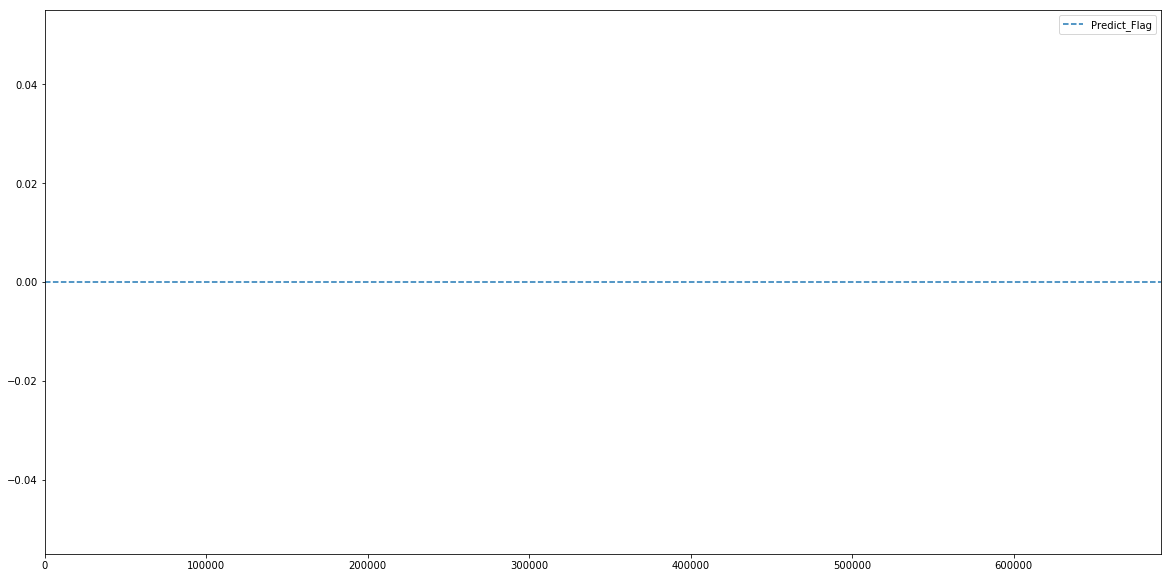

In [17]:
y_predict_df = pd.DataFrame(predicted_flag_array[0:n_timesteps], columns=['Predict_Flag'])

y_predict_df.plot(style=['--'], figsize=(20,10))

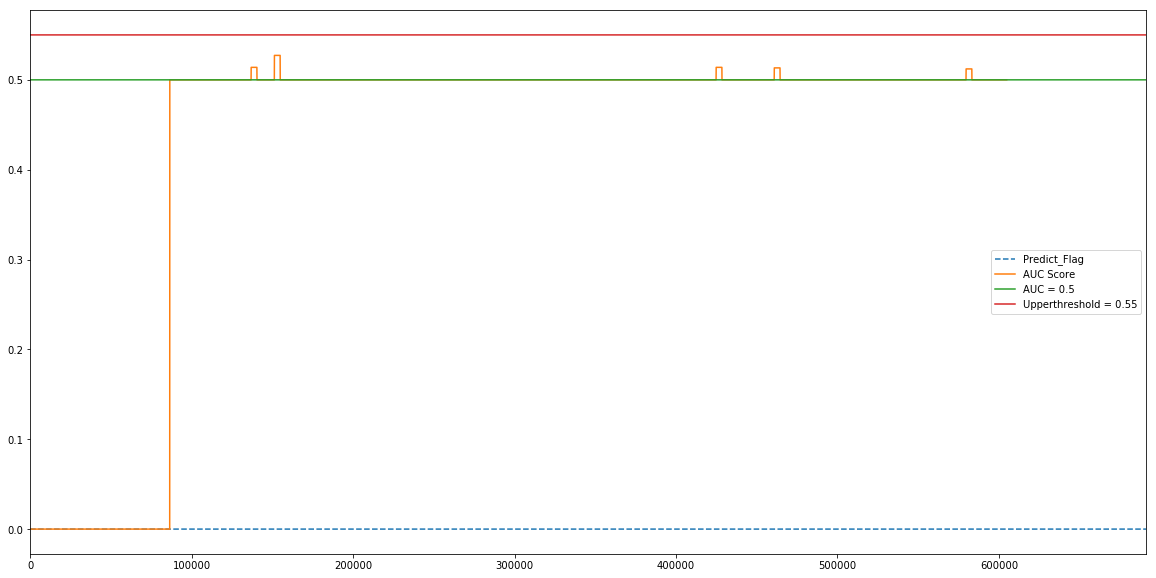

In [18]:
half_array = np.zeros(n_timesteps, dtype=np.float)
half_array.fill(0.5)
#print half_array
half_df = pd.DataFrame(half_array[0:n_timesteps], columns=['AUC = 0.5'])

upper_threshold_array = np.zeros(n_timesteps, dtype=np.float)
upper_threshold_array.fill(0.55)
upper_threshold_df = pd.DataFrame(upper_threshold_array[0:n_timesteps], columns=['Upperthreshold = 0.55'])

auc_score_df = pd.DataFrame(auc_score_array[0:n_timesteps], columns=['AUC Score'])

tuner = pd.concat([y_predict_df, auc_score_df], axis=1)
tuner2 = pd.concat([tuner, half_df], axis=1)
tuner3 = pd.concat([tuner2, upper_threshold_df], axis=1)
tuner3.plot(style=['--', '-', '-', '-'], figsize=(20,10))

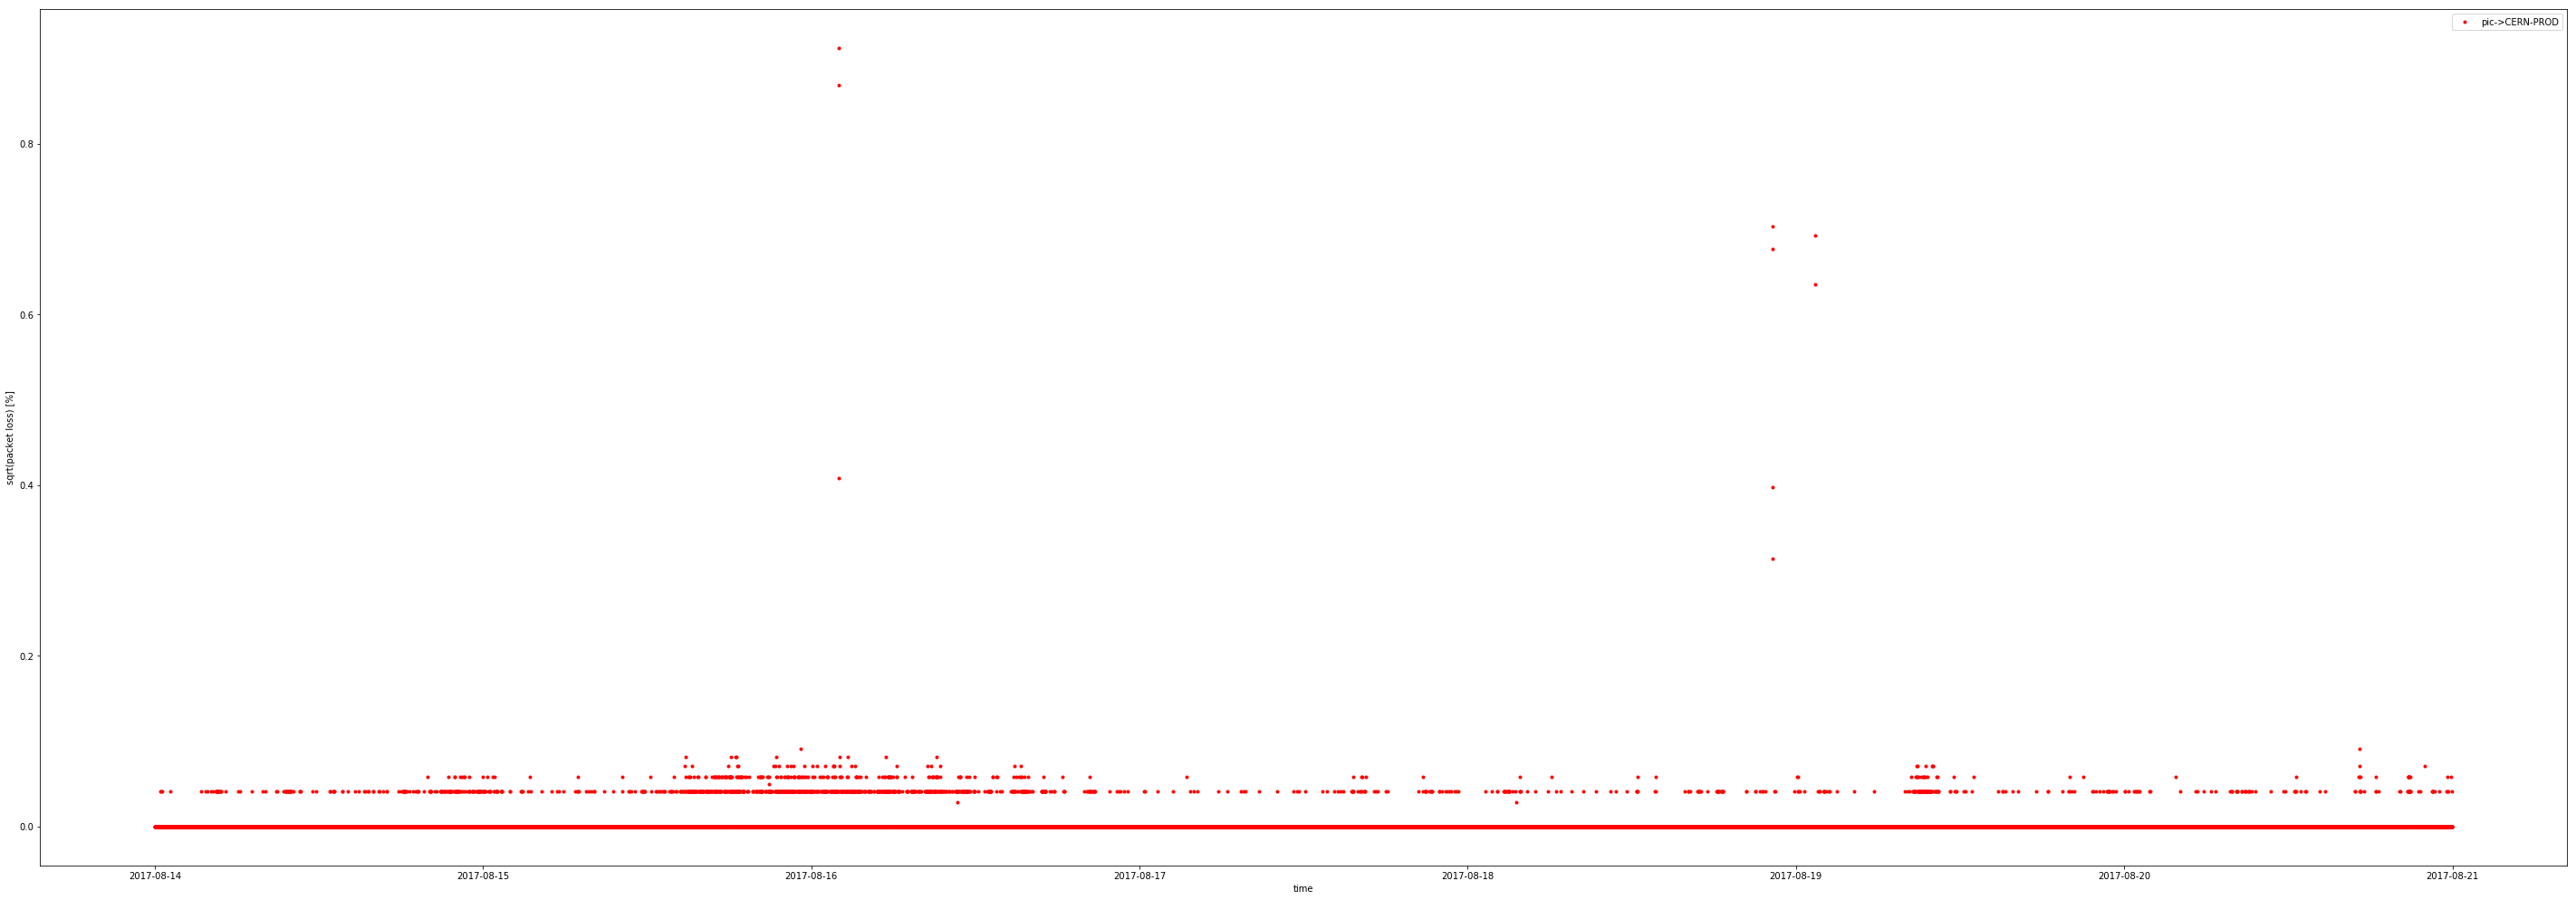

In [19]:
plt.figure(figsize=[50, 80])
gs = gridspec.GridSpec(4, 1)

ax2 = plt.subplot(gs[1])
ax2.plot(Fpl.timestamp.tolist(), np.sqrt(Fpl.packet_loss).tolist(), ls='', marker='.', c='r', label=sS+'->'+dS)
ax2.set_xlabel('time')
ax2.set_ylabel('sqrt(packet loss) [%]')
ax2.legend()

plt.show()

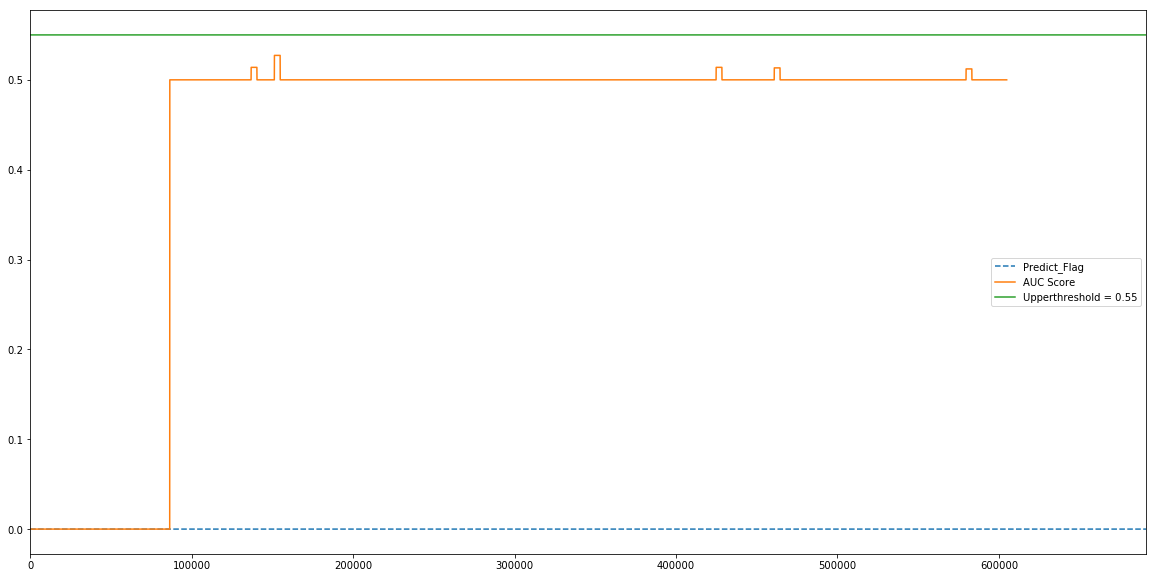

In [20]:
half_array = np.zeros(n_timesteps, dtype=np.float)
half_array.fill(0.5)
#print half_array

upper_threshold_array = np.zeros(n_timesteps, dtype=np.float)
upper_threshold_array.fill(0.55)
upper_threshold_df = pd.DataFrame(upper_threshold_array[0:n_timesteps], columns=['Upperthreshold = 0.55'])

auc_score_df = pd.DataFrame(auc_score_array[0:n_timesteps], columns=['AUC Score'])

tuner = pd.concat([y_predict_df, auc_score_df], axis=1)
tuner3 = pd.concat([tuner, upper_threshold_df], axis=1)
tuner3.plot(style=['--', '-', '-',], figsize=(20,10))